# Material Identification

## Acknowledgements

I would like to give credit to Madjek, Inc. in Amityville, NY who provided the facilities for data collection and helped to advise in the business case scenario for this project. Although this scenario is a fictitious one, they were still happy to serve as an example for this data investigation, and we thank them for their support.

## Business Problem

To develop a Covolutional Nueral Network that can properly identify material types for warehouse and scrap material handling.

Our client Madjek, Inc. is a store fixture manufacturer who purchases a variety of sheet good materials for different jobs. They would like to install a material handling system which would keep track of their sheet good products in their warehouse.+ For the installation of this system, they would also like to eliminate barcodes and barcode scanners that would typically be used to track materials, so as to reduce the amount of employees required for material handling, as well as reduce human error in handling. In order to do this, they will need to have a system in place (using cameras and scanners) which would automatically recognize the type of material in a given situation. The system would need to recognize the material at certain intervals in material handling:

- When the material is offloaded from a truck and placed into the warehouse
- When the material is cut on the panel saw and then stored in with scrap cuts in the warehouse
- To serve as a quality control check at the CNC routers to confirm the correct material has been placed on the machine

The company has 4 main types of materials that they work with that they would like to have classified:

- MDF
- TFL / Particle Core with HPL
- Particle Core
- Veneer Core


## The Dataset

The images in this dataset contains around 2000 images that were taken at varying view points in both the warehouse and the scrap racks. All images were taken on a Iphone 13 pro camera. Across the range of images, there are a variety of lighting conditions, as well as a variety of close up and far away images. The far away images were taken within the warehouse, and are used to identify an entire stack of material, where the material will be the same for the entire stack. The close up images vary for both the warehouse and the scrap racks, where the piece of material that is centered in the image is what is identified as the material type.

The original Madjek_NoClass folder contains all of the images for the project. A separate notebook named "Train-Split-Multiclass-Images" was created in order to organize the images into subfolders by class (which were stored in the "Madjek_Class" folder) and then subsequently break the images into train, test, and validation sets (which were stored in the "Madjek" folder).

There is also a Data_image_target csv file, which contains a column for the image file name, and a column for the material type of the image.

## Reading and Analyzing the Data

We will start by importing the libraries required for the notebook and pulling in the data as well as ignoring warning which were raised and addressed in completing the folowing notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import argparse
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras.models import Sequential
from tensorflow.keras.utils import plot_model

Lets take a look at some of the image files to get a better idea of the data we are working with.

In [3]:
def imgfileshow(filenames, directory, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.load_img((directory + '/' + IM), target_size=None)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

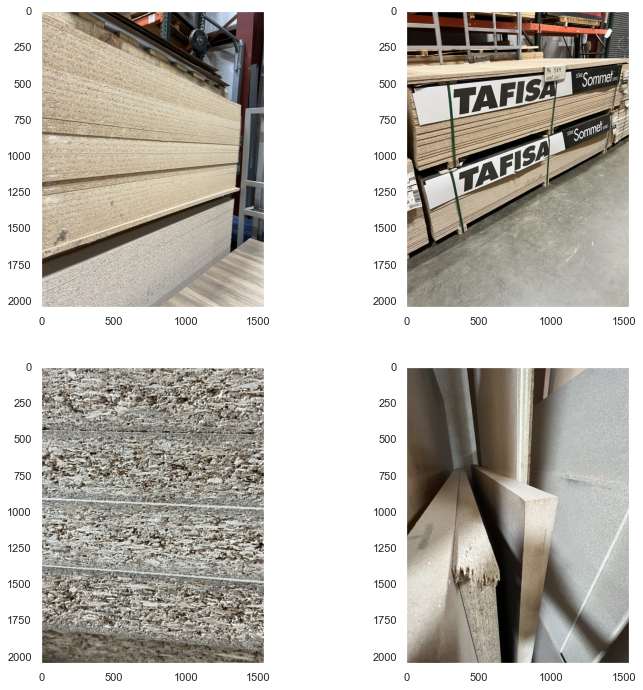

In [4]:
IMGtoLoad = ['IMG_1114.jpeg', 'IMG_1125.jpeg', 'IMG_1583.jpeg', 'IMG_1743.jpeg']

imgfileshow(IMGtoLoad, f'images/Madjek_NoClass', 2, 2)

We have a couple problems in these images that we will have to deal with. 

- The images are large (1536 x 2048), we will need to scale them down in order to reduce the modeling time
- Some images contain one piece of material and others contain a stack of material. By looking at the corresponding labels for the images, it looks like the material at the center of the image is what is being identified. We will need to crop the images to only include the center area of the image for proper identification
- Some images are close up and some images are taken far away. Not sure how we will deal with this, but will have to come back to it.



Lets take a look at the proportions of each of the classes we have in the csv file

In [5]:
df_target = pd.read_csv('images/Data_Image_Target.csv')
df_target

,IMG,Mat
0,IMG_1089,PC
1,IMG_1090,PC
2,IMG_1091,PC
3,IMG_1092,PC
4,IMG_1093,PC
...,...,...
2056,IMG_3148,TFL
2057,IMG_3149,TFL
2058,IMG_3150,TFL
2059,IMG_3151,TFL


In [6]:
print(df_target["Mat"].value_counts())

TFL    825
PC     619
MDF    309
VC     308
Name: Mat, dtype: int64


In [7]:
# Calculate percentages for each failure
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[40.03, 30.03, 14.99, 14.94]

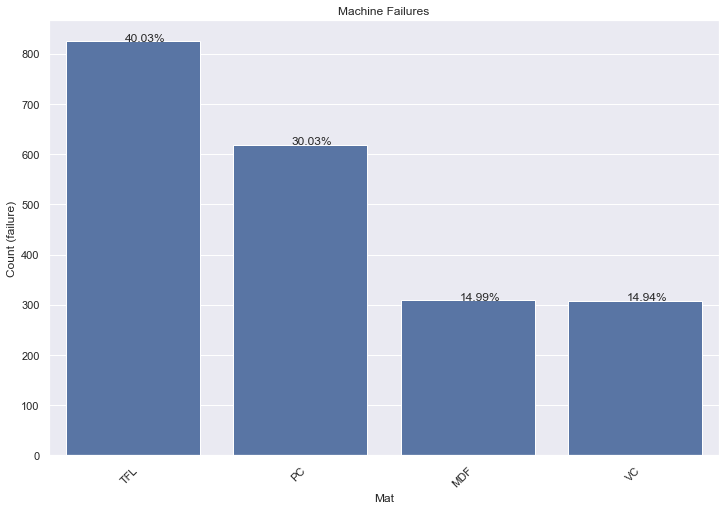

In [8]:
# Plot failure types and percentages in barplot

Mat_type = df_target['Mat'].value_counts(sort=True)
Value_counts = df_target["Mat"].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Mat_type.index, y=Mat_type.values, color='b')
ax.set(xlabel="Mat", ylabel="Count (failure)", title="Machine Failures")
plt.xticks(rotation=45, ha='right', rotation_mode="anchor")

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

The TFL class seems to have the most amount of data points at 40% of the entire dataset, with PC coming in second at 30% and MDF and VC coming in at 15%. So it seems that we have a slight class imbalance between them all. We may want to implement some techniques that will reduce the issues of this imbalance in the dataset.

## Preprocessing Data

### Nulls and count

Lets just double check the target data for any nulls or problems in that set before moving forward.

In [9]:
df_target.isnull().sum()

IMG    0
Mat    0
dtype: int64

In [10]:
df_target.describe()

,IMG,Mat
count,2061,2061
unique,2061,4
top,IMG_1685,TFL
freq,1,825


In [11]:
# folder path
dir_path = r'C:\Users\Tim\Documents\Flatiron\Phase_4\Mold-Spatial-Recognition\images\Madjek_NoClass'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

File count: 2061


There are no nulls in the csv file and the count of images matches the count of rows in the csv file. Lets analyze the images to see if there are any blurry images which would be problematic 

### Blurry Images

All of these images were taken by hand, so we may have some images that are blurry. For any images that are blurry, we will want to remove them so as to improve our accuracy.

We will start by performing preprocessing on the four images we pulled as a sample from the dataset, once complete we will then apply the preprocessing to the entire dataset

In [12]:
sam_imgs = [tf.io.decode_image((tf.io.read_file(f'images/Madjek_NoClass/{IM}')), channels=3, dtype=tf.dtypes.float32) for IM in IMGtoLoad]

In [13]:
crpimgs = tf.image.central_crop(sam_imgs, 0.4)

In [14]:
def tensorimgshow(filenames, cols, rows):
    imgs = []
    fig, axes = plt.subplots(ncols=cols, nrows=rows, figsize=(12,12))
    for count, IM in enumerate(filenames):
        img = image.array_to_img(IM)
        ax = axes[count//cols][count%cols]
        ax.imshow(img)
        ax.grid(False)
        imgs.append(img)

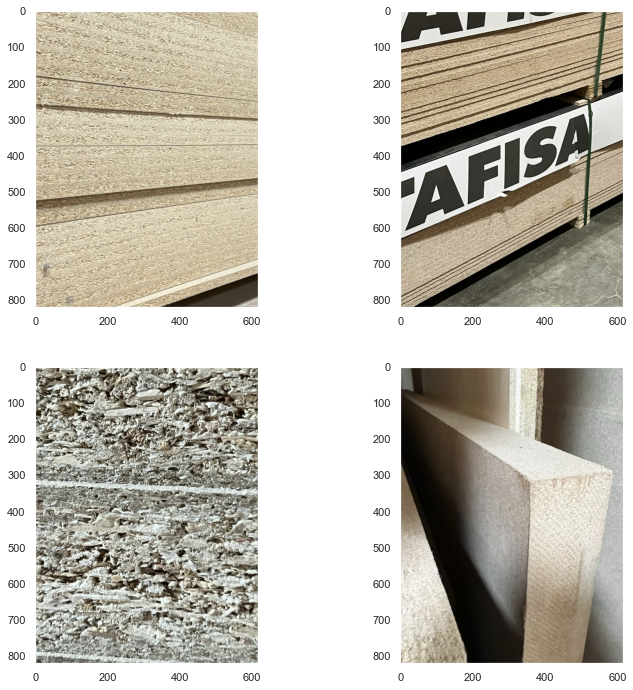

In [15]:
tensorimgshow(crpimgs, 2, 2)

IN order to futher improve processing time, we will also resize the dpi for the images

In [31]:
img_height = 512
img_width = 384

In [32]:
crpsizeimgs = tf.image.resize(crpimgs, [img_height, img_width])

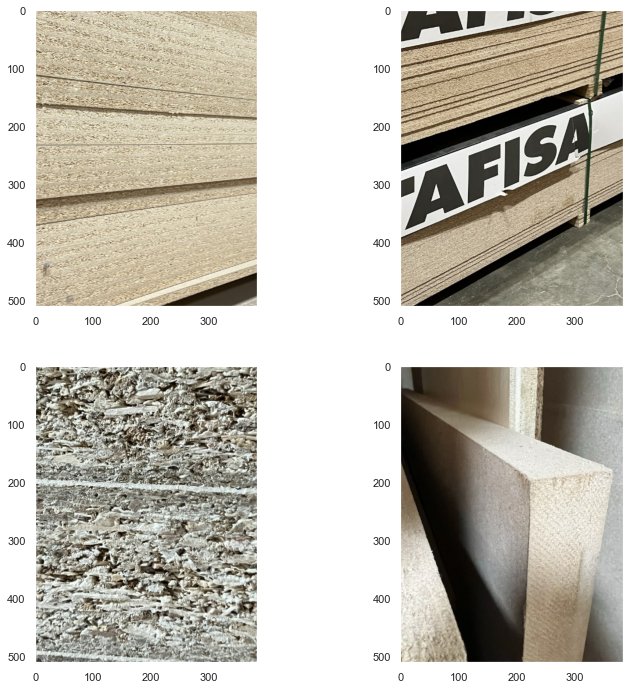

In [33]:
tensorimgshow(crpsizeimgs, 2, 2)

Now that our images are processed, we will take them and combine them 

## Preparing the Data for Modeling

Our images have been split beforehand into separate train, test, and validation folders. One thing we will need to do is assign these images to the proper variables in order to process them through our Convolutional Neural Network.

In [78]:
train_dir = "images/Madjek/train/"
test_dir = "images/Madjek/test/"
val_dir = "images/Madjek/val/"

In [79]:
batch_size =  32

In [80]:
# transfer data from directories to batches

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,                                               
    batch_size = batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical',
    seed = 42)

Found 1976 files belonging to 4 classes.
Found 401 files belonging to 4 classes.
Found 389 files belonging to 4 classes.


In [91]:
train_data_cropped = tf.image.resize(train_data, [img_height, img_width])

ValueError: Attempt to convert a value (<BatchDataset shapes: ((None, 512, 384, 3), (None, 4)), types: (tf.float32, tf.float32)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>) to a Tensor.

In [81]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 512, 384, 3)
(32, 4)


In [82]:
classes=list(train_data.class_names)
num_classes=len(classes)
num_classes

4

## Baseline CNN

In [83]:
# Create baseline model
base_model = models.Sequential()

# Add the appropriate layers
base_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_height, img_width, 3)))
base_model.add(layers.MaxPooling2D())

base_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
base_model.add(layers.MaxPooling2D())

base_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_model.add(layers.MaxPooling2D())

base_model.add(layers.Flatten())
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(num_classes, activation='softmax'))



In [84]:
# Compile the model
base_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer="adam",
              metrics=['accuracy'])

In [85]:
# Return a summary of our model
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 510, 382, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 255, 191, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 252, 188, 32)      16416     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 126, 94, 32)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 124, 92, 64)       18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 62, 46, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 182528)           

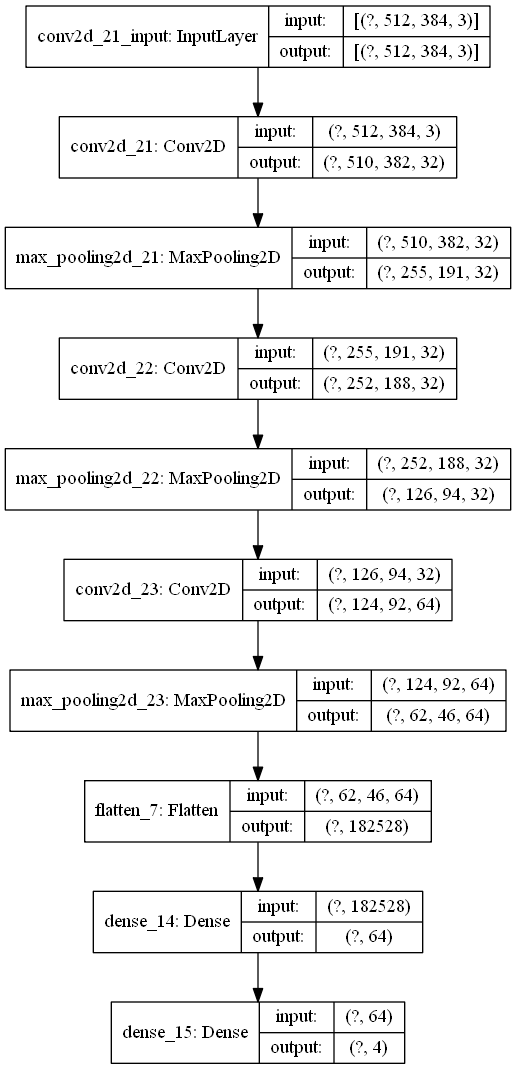

In [86]:
# Return image of model's architecture
plot_model(base_model, show_shapes=True, show_layer_names=True)

In [87]:

epochs=5
history = base_model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/5
62/62 [==============================] - 231s 4s/step - loss: 87.8069 - accuracy: 0.3532 - val_loss: 1.1620 - val_accuracy: 0.5347
Epoch 2/5
62/62 [==============================] - 221s 4s/step - loss: 1.1031 - accuracy: 0.5359 - val_loss: 0.8024 - val_accuracy: 0.6967
Epoch 3/5
62/62 [==============================] - 221s 4s/step - loss: 0.6269 - accuracy: 0.7566 - val_loss: 0.5289 - val_accuracy: 0.8355
Epoch 4/5
62/62 [==============================] - 222s 4s/step - loss: 0.3017 - accuracy: 0.9104 - val_loss: 0.4565 - val_accuracy: 0.8766
Epoch 5/5
62/62 [==============================] - 228s 4s/step - loss: 0.1346 - accuracy: 0.9651 - val_loss: 0.4959 - val_accuracy: 0.8946


In [88]:
base_model.evaluate(test_data)

13/13 [==============================] - 10s 743ms/step - loss: 0.5644 - accuracy: 0.8878


[0.5643818378448486, 0.8877805471420288]

In [89]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

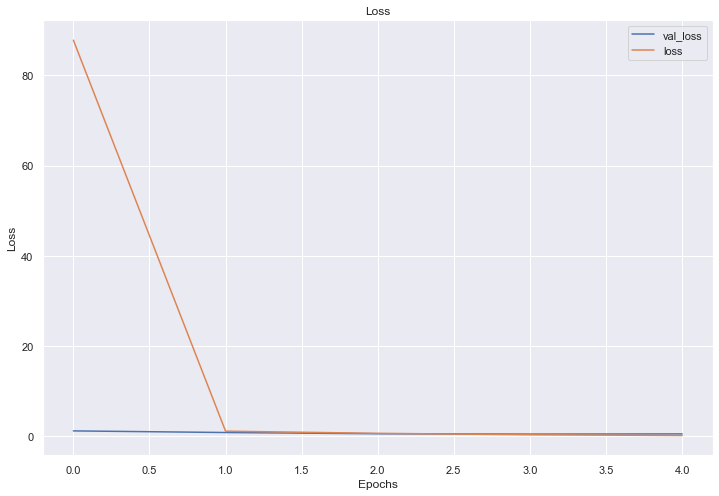

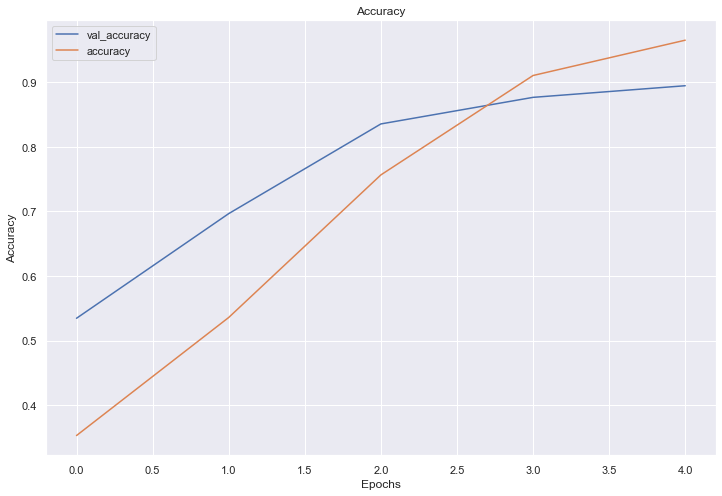

In [90]:
visualize_training_results(history)

Looks like from the base model we have a good start. We wil try to normalize the data to see if that improves our performance

## Fine-Tuning and Refitting

In [ ]:
initial_epochs = 10
fine_tune_epochs = initial_epochs + 1

# Refit the model
history_2 = model_0.fit(train_data,
                       epochs = fine_tune_epochs,
                       validation_data = val_data,
                       validation_steps = int(0.25*len(val_data)),
                       initial_epoch =  history.epoch[-1],) # Start the epoch where it left before

## Transfer Learning